In [1]:
import h5py
import os

import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as etree

from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.models import Model


Process annotations

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/annotations.zip", 'r')
zip_ref.extractall("/content/annotations")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    fname = z.find('./filename').text
    dicts = [{obj.find('name').text: [int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))]}
             for obj in objects]
    return {'size': size, 'filename': fname, 'objects': dicts}

In [ ]:
# Filters annotations keeping only those we are interested in.
# We only keep images in which there is a single item
annotations = []

filters = ['dog', 'cat']
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

ANNOTATION_DIR = '/content/annotations'
for filename in sorted(os.listdir(ANNOTATION_DIR)):
    annotation = extract_xml_annotation(os.path.join(ANNOTATION_DIR, filename))

    new_objects = []
    for obj in annotation['objects']:
        if list(obj.keys())[0] in filters:
            new_objects.append(obj)

    if len(new_objects) == 1:
        annotation['class'] = list(new_objects[0].keys())[0]
        annotation['bbox'] = list(new_objects[0].values())[0]
        annotation.pop('objects')
        annotations.append(annotation)


In [ ]:
print(f'Number of images with annotations: {len(annotations)}.')


Number of images with annotations: 3685.


Sample images

In [6]:
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/images (1).zip", 'r')
zip_ref.extractall("/content/images")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


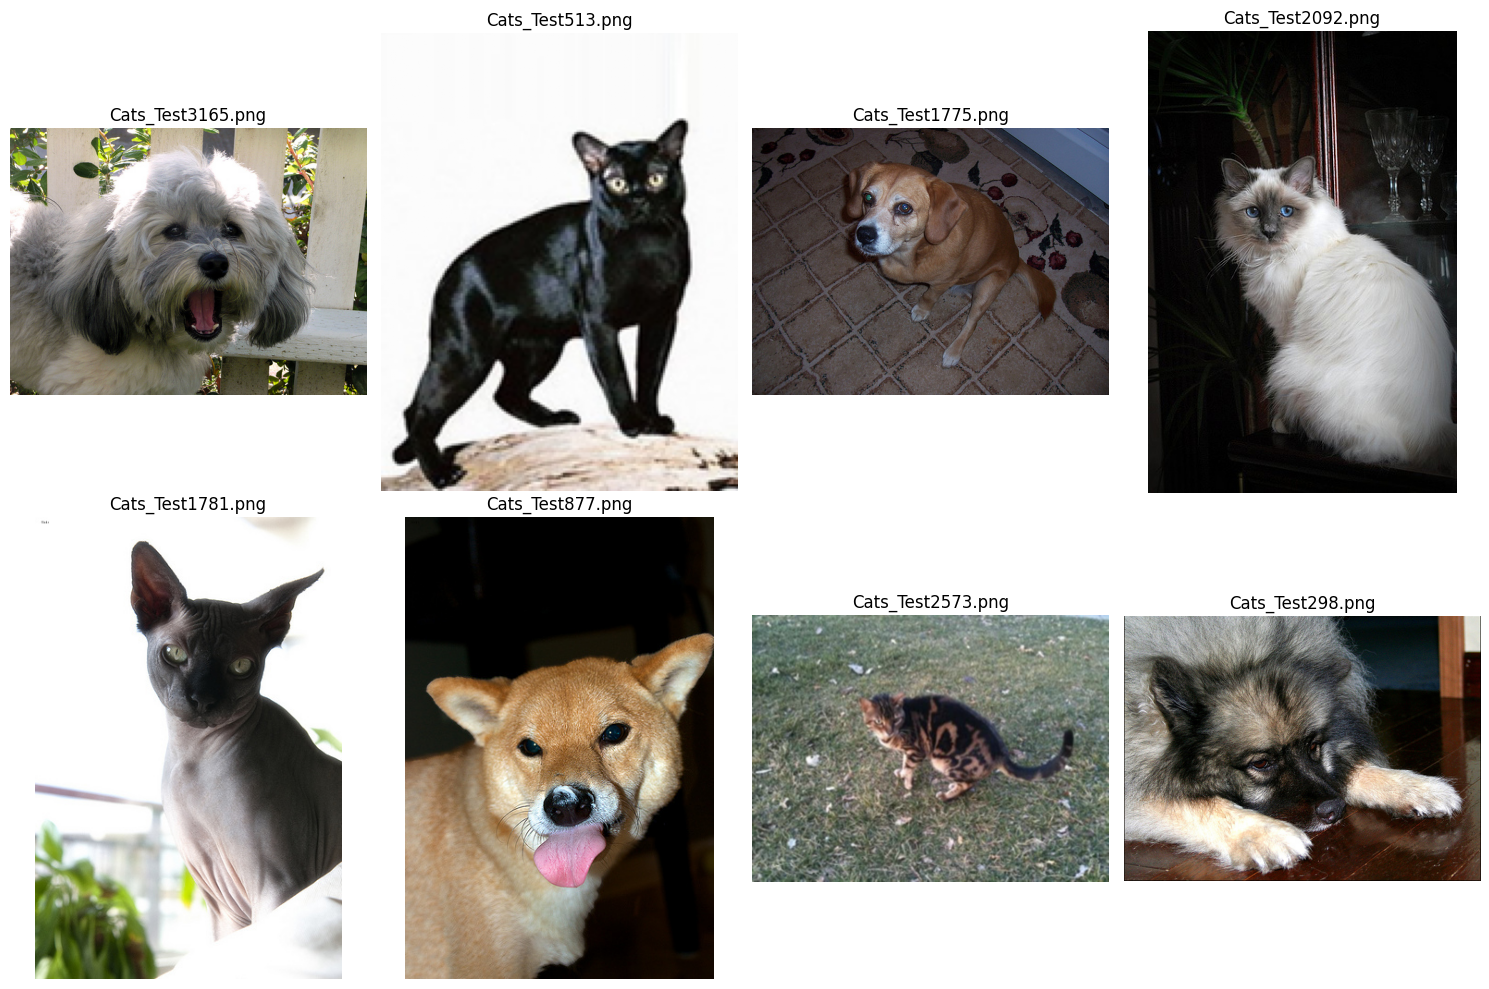

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMG_DIR = '/content/images/'
num_samples = 8  # Number of sample images you want to display

# List all files in the directory
files = os.listdir(IMG_DIR)

# Filter out non-image files (if any)
image_files = [f for f in files if f.endswith('.jpg') or f.endswith('.png')]

# Randomly select 'num_samples' images from the directory
sample_files = random.sample(image_files, num_samples)

# Plot the sample images
plt.figure(figsize=(15, 10))
for i, filename in enumerate(sample_files):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(os.path.join(IMG_DIR, filename))
    plt.imshow(img)
    plt.title(filename)
    plt.axis('off')

plt.tight_layout()
plt.show()

Pre-computing representaiton

In [ ]:
model = ResNet50(include_top=False, weights="imagenet")
input_tensor = model.layers[0].input
output_tensor = model.layers[-2].output
model_conv = Model(input_tensor, output_tensor)

In [ ]:
def predict_batch(model, img_batch_path, img_size=None):
    img_list = []
    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = resize(img, (224,224,3),
                         mode='reflect',
                         preserve_range=True)
        img = img.astype('float32')
        img_list.append(img)
    img_batch = np.stack(img_list, axis=0)
    return model(preprocess_input(img_batch)).numpy()

In [ ]:
# Test the model
IMG_DIR = '/content/images'
IMG_PATH = os.path.join(IMG_DIR, annotations[20]['filename'])
output = predict_batch(model_conv, [IMG_PATH], (1000, 224))
print(f'Shape of the output: {output.shape}')

Shape of the output: (1, 7, 7, 2048)


In [ ]:
def compute_representations(annotations):
    batch_size = 64
    batches = []

    n_batches = len(annotations) // 32 + 1
    for batch_idx in range(n_batches):
        batch_bgn = batch_idx * 32
        batch_end = min(len(annotations), (batch_idx + 1) * 32)
        img_names = []
        for annotation in annotations[batch_bgn:batch_end]:
            img_path = os.path.join(IMG_DIR, annotation['filename'])
            img_names.append(img_path)
        batch = predict_batch(model_conv, img_names, img_size=(224, 224))
        batches.append(batch)
        print(f'Batch {batch_idx + 1}/{n_batches} prepared')
    return np.vstack(batches)

In [ ]:
reprs = compute_representations(annotations)


Batch 1/116 prepared
Batch 2/116 prepared
Batch 3/116 prepared
Batch 4/116 prepared
Batch 5/116 prepared
Batch 6/116 prepared
Batch 7/116 prepared
Batch 8/116 prepared
Batch 9/116 prepared
Batch 10/116 prepared
Batch 11/116 prepared
Batch 12/116 prepared
Batch 13/116 prepared
Batch 14/116 prepared
Batch 15/116 prepared
Batch 16/116 prepared
Batch 17/116 prepared
Batch 18/116 prepared
Batch 19/116 prepared
Batch 20/116 prepared
Batch 21/116 prepared
Batch 22/116 prepared
Batch 23/116 prepared
Batch 24/116 prepared
Batch 25/116 prepared
Batch 26/116 prepared
Batch 27/116 prepared
Batch 28/116 prepared
Batch 29/116 prepared
Batch 30/116 prepared
Batch 31/116 prepared
Batch 32/116 prepared
Batch 33/116 prepared
Batch 34/116 prepared
Batch 35/116 prepared
Batch 36/116 prepared
Batch 37/116 prepared
Batch 38/116 prepared
Batch 39/116 prepared
Batch 40/116 prepared
Batch 41/116 prepared
Batch 42/116 prepared
Batch 43/116 prepared
Batch 44/116 prepared
Batch 45/116 prepared
Batch 46/116 prepar

In [ ]:
img_resize = 224
num_classes = len(labels2idx.keys())

def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation['class']]
        cls[cls_idx] = 1.0

        coords = annotation['bbox']
        size = annotation['size']

        # Resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])

        # Compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # Stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [ ]:
classes, boxes = tensorize_ground_truth(annotations)


In [ ]:
def IoU(boxA, boxB):
    # Find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)

    # Compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas minus the intersection areas
    return inter_area / float(boxA_area + boxB_area - inter_area)

### Customize CNN Model

In [ ]:
def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white', bbox={'facecolor':color, 'alpha':0.5})

def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "GT " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = f'{annotation["confidence"]:0.2f} '
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')

def display(model, index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations(IMG_DIR + annotations[index]["filename"],
                     output, annotations[index] if ground_truth else None)

In [ ]:
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = IoU(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [ ]:
def compute_acc(model, train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "Train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations)
        split_name = "Test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)

    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)

    print(f'{split_name} acc: {acc:0.3f}, mean IoU: {iou:0.3f}, acc_valid: {valid:0.3f}')

In [ ]:
model_input = Input(shape=(7, 7, 2048))
C1 = Convolution2D(32, (3, 3), padding='same', activation='relu')(model_input)
S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(C1)
C3 = Convolution2D(64, (3, 3), padding='same', activation='relu')(S2)
S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(C3)
C5 = Convolution2D(128, (3, 3), padding='same', activation='relu')(S4)
S6 = MaxPooling2D(pool_size=(2, 2), padding="same")(C5)
flat = Flatten()(S6)
F7 = Dense(128, activation='relu', use_bias=True)(flat)
head_classes = Dense(num_classes, activation='softmax', name='head_classes')(F7)
head_boxes = Dense(4, name='head_boxes')(F7)
model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
model.compile(optimizer='adam', loss=[categorical_crossentropy, 'mse'], loss_weights=[1., 1 / (224 * 224)])


In [ ]:
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(f'Length of the train set: {train_num}, length of the test set: {test_num}')

Length of the train set: 3317, length of the test set: 368


In [ ]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

In [ ]:
history = model.fit(inputs, y=[out_cls, out_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=10, verbose=2)

Epoch 1/10
104/104 - 32s - loss: 0.3052 - head_classes_loss: 0.1902 - head_boxes_loss: 5767.4424 - val_loss: 0.1144 - val_head_classes_loss: 0.0663 - val_head_boxes_loss: 2413.7205 - 32s/epoch - 308ms/step
Epoch 2/10
104/104 - 25s - loss: 0.0712 - head_classes_loss: 0.0323 - head_boxes_loss: 1948.9471 - val_loss: 0.0588 - val_head_classes_loss: 0.0251 - val_head_boxes_loss: 1687.6774 - 25s/epoch - 240ms/step
Epoch 3/10
104/104 - 24s - loss: 0.0515 - head_classes_loss: 0.0222 - head_boxes_loss: 1472.3568 - val_loss: 0.0706 - val_head_classes_loss: 0.0425 - val_head_boxes_loss: 1413.8464 - 24s/epoch - 233ms/step
Epoch 4/10
104/104 - 26s - loss: 0.0350 - head_classes_loss: 0.0095 - head_boxes_loss: 1277.8969 - val_loss: 0.0421 - val_head_classes_loss: 0.0154 - val_head_boxes_loss: 1337.6133 - 26s/epoch - 248ms/step
Epoch 5/10
104/104 - 28s - loss: 0.0209 - head_classes_loss: 5.0100e-04 - head_boxes_loss: 1021.7868 - val_loss: 0.0281 - val_head_classes_loss: 0.0076 - val_head_boxes_loss: 1

In [ ]:
model.save('classify_detect_model1.h5')

In [ ]:
from keras.models import load_model

model = load_model('classify_detect_model1.h5')

In [ ]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]

    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {'class': classname, 'confidence': confidence, 'bbox': fullsize_box}
    return output

In [ ]:
compute_acc(model, train=True)
compute_acc(model, train=False)

104/104 [==============================] - 13s 120ms/step
Train acc: 1.000, mean IoU: 0.558, acc_valid: 0.693
12/12 [==============================] - 1s 60ms/step
Test acc: 0.997, mean IoU: 0.317, acc_valid: 0.228


1/1 [==============================] - 0s 31ms/step


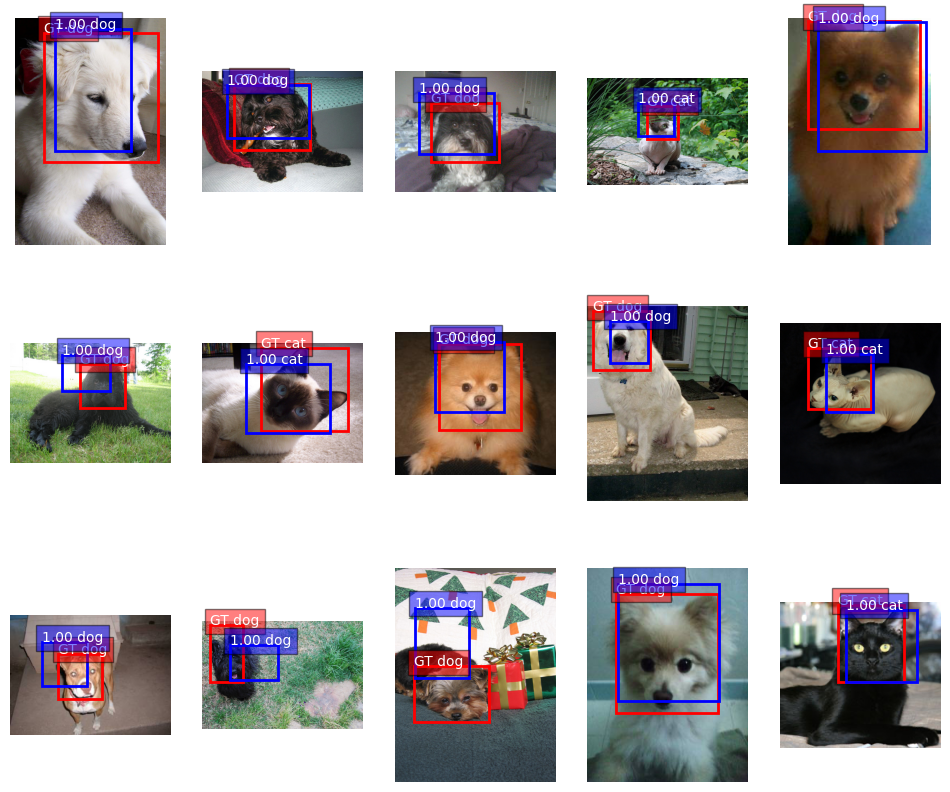

In [ ]:
IMG_DIR = '/content/images/'

plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("classify_detect_model1.h5")

# Print the model summary
model.summary()

Model: "resnet_loc"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7, 7, 2048)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 32)             589856    ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 4, 4, 64)             18496     ['max_pooling2d[0][0]

## InceptionV3 Model

In [ ]:
from bs4 import BeautifulSoup


In [ ]:
directory = '/content/annotations'
annotations = os.listdir(directory)

records = []
for annot_file in annotations:

    with open(os.path.join(directory,annot_file), 'r') as f:
        file = f.read()
    data = BeautifulSoup(file, "xml")

    objects = data.find_all('object')
    length = len(objects)
    filename = data.find("filename").text
    img_width = int(data.find('size').width.text)
    img_height = int(data.find('size').height.text)

    for i in range(length):
        class_name = data.find_all('object')[i].find('name').text
        xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)/img_width
        ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)/img_height
        xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)/img_width
        ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)/img_height

        records.append([filename,class_name,xmin,ymin,xmax,ymax])

In [ ]:
df = pd.DataFrame(records,columns=['filename','class','xmin','ymin','xmax','ymax'])
df.drop_duplicates(subset=['filename'],inplace=True)
df['class'] = df['class'].apply(lambda x: 1.0 if x=='dog' else 0.0)
df

,filename,class,xmin,ymin,xmax,ymax
0,Cats_Test123.png,0.0,0.368000,0.170667,0.758000,0.706667
1,Cats_Test1728.png,0.0,0.352000,0.103070,0.818000,0.585526
2,Cats_Test724.png,1.0,0.170391,0.198000,0.997207,0.880000
3,Cats_Test944.png,1.0,0.454000,0.261006,0.604000,0.440252
4,Cats_Test2366.png,1.0,0.283333,0.235556,0.556667,0.524444
...,...,...,...,...,...,...
3682,Cats_Test2112.png,0.0,0.548387,0.059041,0.800000,0.321033
3683,Cats_Test2000.png,1.0,0.267267,0.182000,0.633634,0.506000
3684,Cats_Test592.png,1.0,0.338000,0.537538,0.498000,0.852853
3685,Cats_Test3547.png,1.0,0.338667,0.390000,0.536000,0.666000


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

class DataGenerator(Sequence):

    def __init__(self, df, X, y1, y2, batch_size, img_size, directory, shuffle=False):
        self.df = df.copy()
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.n = len(self.df)
        print(f"Number of records: {self.n}")
        print(f"Number of steps: {-(self.n // -self.batch_size)}")

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return -(self.n // -self.batch_size)

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y1, y2 = self.__get_data(batch)
        return X, (y1,y2)

    def __get_data(self,batch):

        X,y1,y2 = [],[],[]
        for i, record in batch.iterrows():
            img = load_img(os.path.join(self.directory,record[self.X]),target_size=(self.img_size,self.img_size))
            img = img_to_array(img)
            img = img/255.
            X.append(img)
            coods = record[self.y1].values
            y1.append(coods)
            y2.append(record[self.y2])

        return np.array(X,dtype=np.float32),np.array(y1,dtype=np.float32),np.array(y2,dtype=np.float32)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# from bboxregressiongenerator import DataGenerator
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import cv2

In [ ]:
directory = '/content/annotations'
annotations = os.listdir(directory)

In [ ]:
records = []
for annot_file in annotations:

    with open(os.path.join(directory,annot_file), 'r') as f:
        file = f.read()
    data = BeautifulSoup(file, "xml")

    objects = data.find_all('object')
    length = len(objects)
    filename = data.find("filename").text
    img_width = int(data.find('size').width.text)
    img_height = int(data.find('size').height.text)

    for i in range(length):
        class_name = data.find_all('object')[i].find('name').text
        xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)/img_width
        ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)/img_height
        xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)/img_width
        ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)/img_height

        records.append([filename,class_name,xmin,ymin,xmax,ymax])

In [ ]:
df = pd.DataFrame(records,columns=['filename','class','xmin','ymin','xmax','ymax'])
df.drop_duplicates(subset=['filename'],inplace=True)
df['class'] = df['class'].apply(lambda x: 1.0 if x=='dog' else 0.0)
df

,filename,class,xmin,ymin,xmax,ymax
0,Cats_Test123.png,0.0,0.368000,0.170667,0.758000,0.706667
1,Cats_Test1728.png,0.0,0.352000,0.103070,0.818000,0.585526
2,Cats_Test724.png,1.0,0.170391,0.198000,0.997207,0.880000
3,Cats_Test944.png,1.0,0.454000,0.261006,0.604000,0.440252
4,Cats_Test2366.png,1.0,0.283333,0.235556,0.556667,0.524444
...,...,...,...,...,...,...
3682,Cats_Test2112.png,0.0,0.548387,0.059041,0.800000,0.321033
3683,Cats_Test2000.png,1.0,0.267267,0.182000,0.633634,0.506000
3684,Cats_Test592.png,1.0,0.338000,0.537538,0.498000,0.852853
3685,Cats_Test3547.png,1.0,0.338667,0.390000,0.536000,0.666000


In [ ]:
image_directory = '/content/images/'
df = df.sample(frac=1).reset_index(drop=True)
train = df.head(3000)
test = df.tail(686).reset_index(drop=True)
train_gen = DataGenerator(train,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)
test_gen = DataGenerator(test,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)

Number of records: 3000
Number of steps: 94
Number of records: 686
Number of steps: 22


In [ ]:
df

,filename,class,xmin,ymin,xmax,ymax
0,Cats_Test762.png,1.0,0.346667,0.160000,0.784000,0.526000
1,Cats_Test238.png,1.0,0.372000,0.005333,0.696000,0.762667
2,Cats_Test1589.png,1.0,0.206000,0.090090,0.724000,0.852853
3,Cats_Test93.png,0.0,0.644000,0.095522,0.938000,0.489552
4,Cats_Test2005.png,0.0,0.592000,0.009975,0.978000,0.548628
...,...,...,...,...,...,...
3681,Cats_Test2292.png,0.0,0.238000,0.039039,0.552000,0.513514
3682,Cats_Test3187.png,0.0,0.302000,0.065672,0.730000,0.704478
3683,Cats_Test2902.png,0.0,0.233735,0.098000,0.831325,0.568000
3684,Cats_Test3453.png,1.0,0.294294,0.240000,0.819820,0.532000


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential

In [ ]:
img_size = 256
base_model = InceptionV3(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model.layers:
    if 'mixed7' in layer.name:
        break
    layer.trainable = False

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output1 = Dense(4, activation='sigmoid', name='bbox_reg')(x)
output2 = Dense(1, activation='sigmoid', name='classifier')(x)
model = Model(inputs=base_model.inputs, outputs=[output1,output2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=['mse','binary_crossentropy'],
             loss_weights=[0.6,0.4],
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=test_gen,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 0.0423 - bbox_reg_loss: 0.0343 - classifier_loss: 0.0543 - bbox_reg_accuracy: 0.6133 - classifier_accuracy: 0.9783
Epoch 1: val_loss improved from inf to 0.02582, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 74s 515ms/step - loss: 0.0423 - bbox_reg_loss: 0.0343 - classifier_loss: 0.0543 - bbox_reg_accuracy: 0.6133 - classifier_accuracy: 0.9783 - val_loss: 0.0258 - val_bbox_reg_loss: 0.0200 - val_classifier_loss: 0.0345 - val_bbox_reg_accuracy: 0.7012 - val_classifier_accuracy: 0.9854
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 0.0174 - bbox_reg_loss: 0.0213 - classifier_loss: 0.0116 - bbox_reg_accuracy: 0.6850 - classifier_accuracy: 0.9973
Epoch 2: val_loss improved from 0.02582 to 0.01305, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 38s 406ms/step - loss: 0.0174 - bbox_reg_loss: 0.0213 - classifier_loss: 0.0116 - bbox_reg_accuracy: 0.6850 - classifier_accuracy: 0.9973 - val_loss: 0.0131 - val_bbox_reg_loss: 0.0115 - val_classifier_loss: 0.0154 - val_bbox_reg_accuracy: 0.7332 - val_classifier_accuracy: 0.9927
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 0.0110 - bbox_reg_loss: 0.0159 - classifier_loss: 0.0036 - bbox_reg_accuracy: 0.7290 - classifier_accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.01305
94/94 [==============================] - 41s 438ms/step - loss: 0.0110 - bbox_reg_loss: 0.0159 - classifier_loss: 0.0036 - bbox_reg_accuracy: 0.7290 - classifier_accuracy: 1.0000 - val_loss: 0.0131 - val_bbox_reg_loss: 0.0090 - val_classifier_loss: 0.0193 - val_bbox_reg_accuracy: 0.7697 - val_classifier_accuracy: 0.9927
Epoch 4/10
94/94 [==============================] - ETA: 0s - loss: 0.0083 - bbox_reg_loss: 0.0122 - classifier_loss: 0.0024 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 37s 391ms/step - loss: 0.0083 - bbox_reg_loss: 0.0122 - classifier_loss: 0.0024 - bbox_reg_accuracy: 0.7673 - classifier_accuracy: 1.0000 - val_loss: 0.0106 - val_bbox_reg_loss: 0.0080 - val_classifier_loss: 0.0146 - val_bbox_reg_accuracy: 0.7930 - val_classifier_accuracy: 0.9942
Epoch 5/10
94/94 [==============================] - ETA: 0s - loss: 0.0069 - bbox_reg_loss: 0.0101 - classifier_loss: 0.0021 - bbox_reg_accuracy: 0.7863 - classifier_accuracy: 1.0000
Epoch 5: val_loss improved from 0.01062 to 0.00986, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 39s 413ms/step - loss: 0.0069 - bbox_reg_loss: 0.0101 - classifier_loss: 0.0021 - bbox_reg_accuracy: 0.7863 - classifier_accuracy: 1.0000 - val_loss: 0.0099 - val_bbox_reg_loss: 0.0065 - val_classifier_loss: 0.0149 - val_bbox_reg_accuracy: 0.7959 - val_classifier_accuracy: 0.9942
Epoch 6/10
94/94 [==============================] - ETA: 0s - loss: 0.0060 - bbox_reg_loss: 0.0086 - classifier_loss: 0.0019 - bbox_reg_accuracy: 0.8173 - classifier_accuracy: 1.0000
Epoch 6: val_loss improved from 0.00986 to 0.00877, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 37s 396ms/step - loss: 0.0060 - bbox_reg_loss: 0.0086 - classifier_loss: 0.0019 - bbox_reg_accuracy: 0.8173 - classifier_accuracy: 1.0000 - val_loss: 0.0088 - val_bbox_reg_loss: 0.0056 - val_classifier_loss: 0.0136 - val_bbox_reg_accuracy: 0.8003 - val_classifier_accuracy: 0.9942
Epoch 7/10
94/94 [==============================] - ETA: 0s - loss: 0.0053 - bbox_reg_loss: 0.0076 - classifier_loss: 0.0017 - bbox_reg_accuracy: 0.8143 - classifier_accuracy: 1.0000
Epoch 7: val_loss did not improve from 0.00877
94/94 [==============================] - 41s 436ms/step - loss: 0.0053 - bbox_reg_loss: 0.0076 - classifier_loss: 0.0017 - bbox_reg_accuracy: 0.8143 - classifier_accuracy: 1.0000 - val_loss: 0.0099 - val_bbox_reg_loss: 0.0052 - val_classifier_loss: 0.0168 - val_bbox_reg_accuracy: 0.8294 - val_classifier_accuracy: 0.9927
Epoch 8/10
94/94 [==============================] - ETA: 0s - loss: 0.0047 - bbox_reg_loss: 0.0068 - classifier_loss: 0.0016 -

In [ ]:
model.save('inception3v.h5')

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

# Replace 'inception3v.h5' with the appropriate file path if necessary
shutil.copy('inception3v.h5', '/content/drive/My Drive/')

'/content/drive/My Drive/inception3v.h5'